# BinWaves example in Cantabria (Validation)

**In this notebook**: 
<br><br>
Here waves are reconstructed at the buoy location for comparison.
<br><br>
Steps:
- Buoy is loaded.
- Kp propagation coefficients and hindcast reconstruction is made at the buoy location.
- Comparison plots and statistics are shown.

In [1]:
import xarray as xr

# Load buoy data and kps

buoy_waves = xr.open_dataset("outputs/bw_rec_dataframe_san_ERA5.nc")

kp_coeffs = (
    xr.open_dataset("outputs/kp_coeffs_san_buoy.nc")
    .expand_dims({"site": [1]})
    .rename({"case": "case_num"})
)
kp_coeffs

<xarray.Dataset> Size: 4MB
Dimensions:   (site: 1, case_num: 696, freq: 29, dir: 24)
Coordinates:
  * site      (site) int64 8B 1
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * dir       (dir) float64 192B 262.5 247.5 232.5 217.5 ... 307.5 292.5 277.5
  * freq      (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
Data variables:
    kp        (site, case_num, freq, dir) float64 4MB 0.0 0.0 0.0 ... 0.0 0.0

In [2]:
import pandas as pd
from utils.operations import transform_CAWCR_WS

model_parameters = pd.read_csv("outputs/swan_cases.csv").to_dict(orient="list")

# Load interest spectra

offshore_spectra, offshore_spectra_case = transform_CAWCR_WS(
    cawcr_dataset=xr.open_dataset(
        "/home/tausiaj/GitHub-GeoOcean/BlueMath/test_data/ERA5_full.nc"
    ),
    subset_parameters=model_parameters,
    available_case_num=kp_coeffs.case_num.values,
)
offshore_spectra

<xarray.Dataset> Size: 98MB
Dimensions:    (dir: 24, freq: 29, time: 17520)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * dir        (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq       (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00
Data variables:
    efth       (time, freq, dir) float64 98MB 0.0 0.0 0.0 ... 0.0 0.0 2.2e-05
    u10m       (time) float32 70kB ...
    v10m       (time) float32 70kB ...
    Wspeed     (time) float32 70kB ...
    Wdir       (time) float32 70kB ...
    Depth      (time) int64 140kB ...

In [3]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

# Reconstruct spectra

# reconstructed_onshore_spectra = reconstruc_spectra(
#     offshore_spectra=offshore_spectra_case,
#     kp_coeffs=kp_coeffs,
# )
# reconstructed_onshore_spectra.to_netcdf("outputs/reconstructed_spectra_san_buoy.nc")

reconstructed_onshore_spectra = xr.open_dataset(
    "outputs/reconstructed_spectra_san_buoy.nc"
)
reconstructed_onshore_spectra

<xarray.Dataset> Size: 98MB
Dimensions:    (site: 1, dir: 24, freq: 29, time: 17520)
Coordinates:
  * site       (site) int64 8B 1
  * dir        (dir) float64 192B 262.5 247.5 232.5 217.5 ... 307.5 292.5 277.5
  * freq       (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
    longitude  float32 4B ...
    latitude   float32 4B ...
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00
Data variables:
    kp         (time, site, freq, dir) float64 98MB ...

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='Hs - Buoy [m]', ylabel='Hs - BinWaves [m]'>,
        <Axes: xlabel='Tp - Buoy [s]', ylabel='Tp - BinWaves [s]'>,
        <Axes: xlabel='Dir - Buoy [°]', ylabel='Dir - BinWaves [°]'>],
       dtype=object))

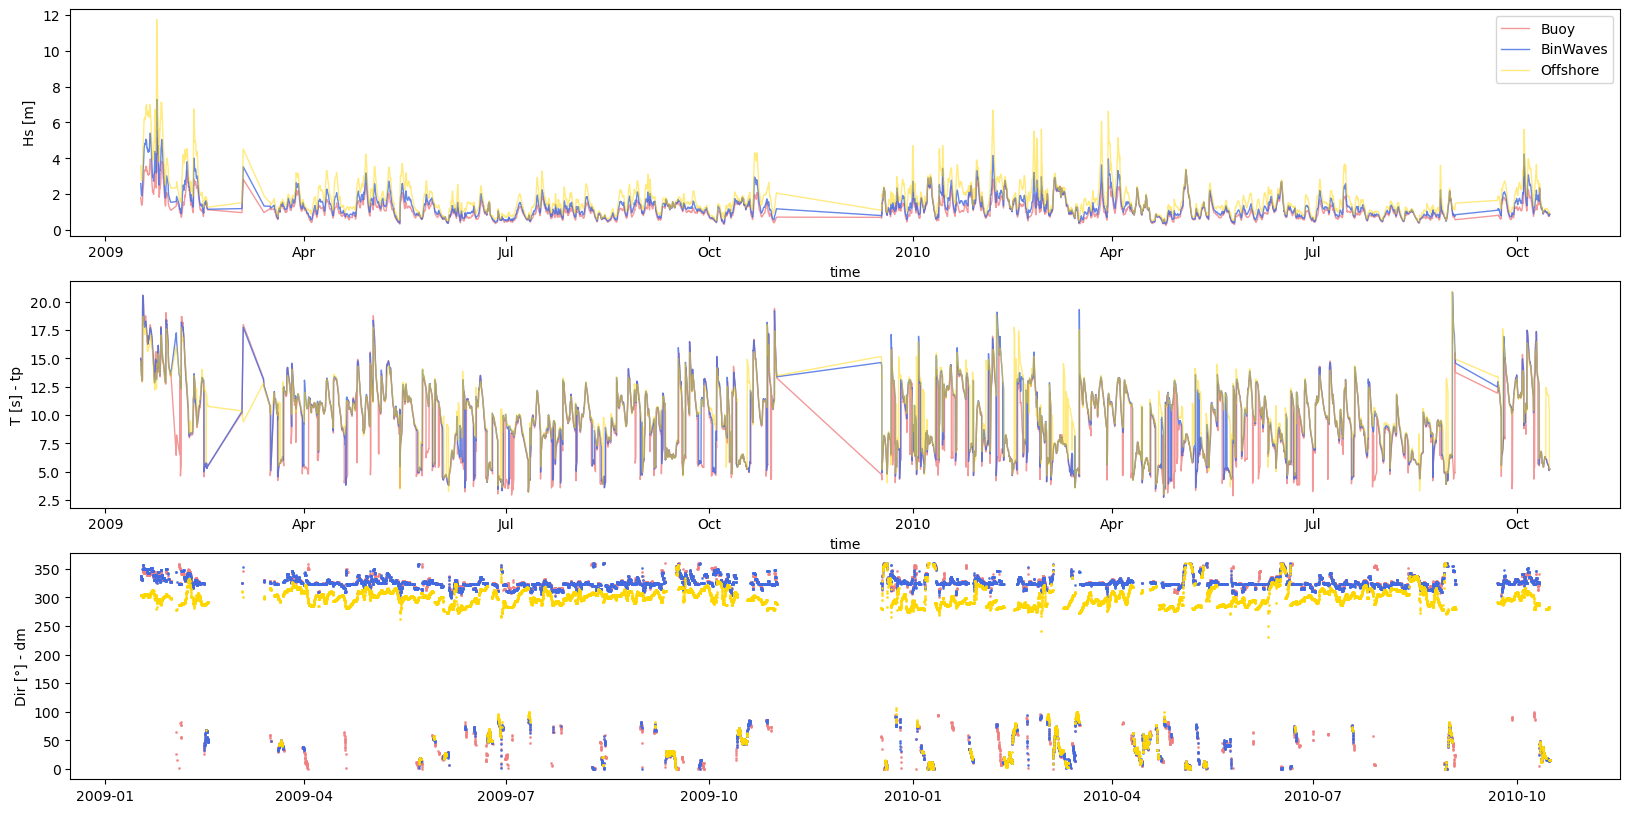

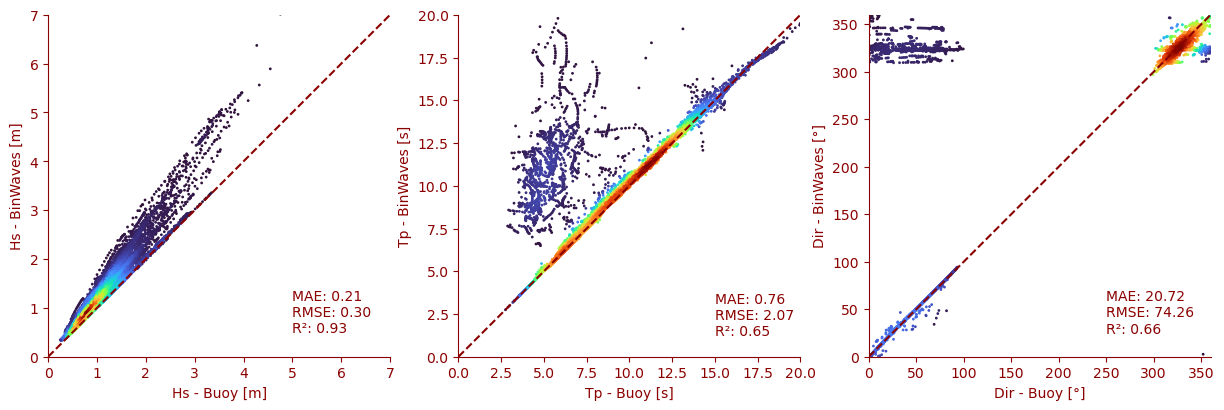

In [4]:
from utils.plotting import plot_wave_series

# Plot reconstructed bulk parameters vs buoy data

plot_wave_series(
    buoy_data=buoy_waves.efth.spec,
    binwaves_data=reconstructed_onshore_spectra.sel(
        site=1, time=buoy_waves.time, method="nearest"
    ).kp.spec,
    offshore_data=offshore_spectra.sel(
        time=buoy_waves.time, method="nearest"
    ).efth.spec,
    times=buoy_waves.time.values,
)